<a href="https://colab.research.google.com/github/eta-lab/cooling-around/blob/main/models/model_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREAMBLE (ABOUT THIS NOTEBOOK)

This notebook applies data prediction with XGBoost model in Python, on time series (hourly) weather data to predict daily thermal comfort exceedances indoors (e.g., when it gets too hot, and by how much). While this notebook contains only the first steps, ultimately it can help determine how much cooling is needed (in terms of mean radiant temperature or MRT), and ultimately help decide on which cooling technologies are feasible and most carbon efficient.

# IMPORTS

In [ ]:
# Install NGBoost and hyperopt
# ! pip install xgboost # this gives version 0.90
! pip install xgboost==1.4.2 # as of Sept 2021 this is most recent stable release

# import all the usual suspects :)
import os
from google.colab import drive
import pickle
import numpy as np
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt

# Sci-kit learn packages for normalizing data and post-processing
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error, matthews_corrcoef, r2_score

# boosting libraries from XGBoost
import xgboost as xgb


print("XGBoost version:", xgb.__version__)

# LOAD THE DATA

The training and testing datasets were pre-processed in a separate notebook saved as separate pickles for 2015,2016 and 2017 (and separated by training and test and output variables based on a prior project) in this public repository:

https://github.com/eta-lab/forecasting-comfort

Details about methods from this project can be found here: Rysanek, A., Nuttall, R., McCarty, J, (2021). Forecasting the impact of climate change on thermal comfort using a weighted ensemble of supervised learning models. Building & Environment.

## MOUNT DRIVE

In [4]:
# Point to the folder for this project (forecasting-MRT-gap/data)
drive.mount('/content/gdrive')
DATA_PATH = "/content/gdrive/My Drive/Colab Notebooks/forecasting-MRT-gap/data"
FIGURES_PATH = "/content/gdrive/My Drive/Colab Notebooks/forecasting-MRT-gap/figures"

Mounted at /content/gdrive


## GET OUTDOOR AIR TEMPERATURES FOR SUMMER 2015, 2016 and 2017

For each year 2015,2016,2017, examine temperature data (outdoor) and prepare to remerge training/test sets (for dynamically selecting training/testing sets from whole)

(5781, 51) (4407, 51) (1374, 51)


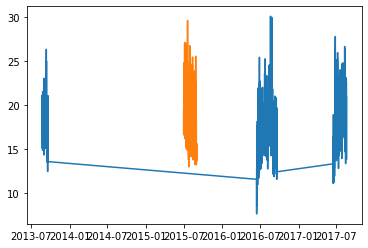

In [85]:
# 2015

dat_train = pickle.load(open(DATA_PATH +'/trainX_2015.pkl','rb'))
dat_test = pickle.load(open(DATA_PATH +'/testX_2015.pkl','rb'))

# check if train and test set are the same, and visualize temp values
df_diff = pd.concat([dat_train,dat_test]).drop_duplicates(keep=False)
print(df_diff.shape, dat_train.shape, dat_test.shape)
df_train = dat_train[['temp']]
df_test = dat_test[['temp']]
plt.plot(df_train.index, df_train.temp, df_test .index, df_test .temp)
plt.show() 

(5739, 51) (4417, 51) (1322, 51)


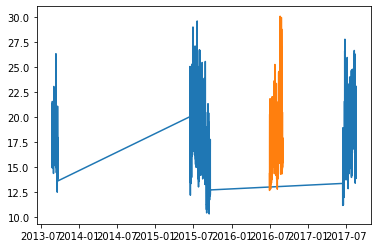

In [86]:
# 2016

dat_train = pickle.load(open(DATA_PATH +'/trainX_2016.pkl','rb'))
dat_test = pickle.load(open(DATA_PATH +'/testX_2016.pkl','rb'))

# check if 2015 train and test set are the same
df_diff = pd.concat([dat_train,dat_test]).drop_duplicates(keep=False)
print(df_diff.shape, dat_train.shape, dat_test.shape)
df_train = dat_train[['temp']]
df_test = dat_test[['temp']]
plt.plot(df_train.index, df_train.temp, df_test .index, df_test .temp)
plt.show() 

(6579, 51) (5028, 51) (1551, 51)


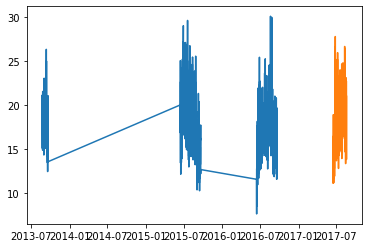

In [87]:
# 2017

dat_train = pickle.load(open(DATA_PATH +'/trainX_2017.pkl','rb'))
dat_test = pickle.load(open(DATA_PATH +'/testX_2017.pkl','rb'))

# check if train and test set are the same, and visualize temp values
df_diff = pd.concat([dat_train,dat_test]).drop_duplicates(keep=False)
print(df_diff.shape, dat_train.shape, dat_test.shape)
df_train = dat_train[['temp']]
df_test = dat_test[['temp']]
plt.plot(df_train.index, df_train.temp, df_test .index, df_test .temp)
plt.show() 

## Restrict to time frames we want 

We want temperature data from all three summers, minus the smoky periods (smoke-affected days = when recorded incidences of regional forest fires)

These are respectively the first two weeks of July 2015 and the first two weeks of August 2017

In [88]:
# 2015

# get training set from another year (so complete for 2015)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2016.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2015-05-23') #*keep last week of May for lag time
remove_after = pd.to_datetime('2015-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# drop smoke weeks (first two weeks July 2015) 
start_smoke = pd.to_datetime('2015-07-01')
end_smoke = pd.to_datetime('2015-07-14')
df_3 = df_2.query('index < @start_smoke or index > @end_smoke')

# save 2015 outdoor temps (x variable)
df_2015_X = df_3 



# 2016 

# get training set from another year (so complete for 2016)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2017.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2016-05-23') #*keep last week of May for lag time
remove_after = pd.to_datetime('2016-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# save 2016 outdoor temps (x variable)
df_2016_X = df_2



# 2017

# get training set from another year (so complete for 2017)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2015.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2017-05-23') #*keep last week of May for lag time
remove_after = pd.to_datetime('2017-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# drop smoke weeks (first two weeks July 2015) 
start_smoke = pd.to_datetime('2017-08-01')
end_smoke = pd.to_datetime('2017-07-14')
df_3 = df_2.query('index < @start_smoke or index > @end_smoke')

# save 2017 outdoor temps (x variable)
df_2017_X = df_3

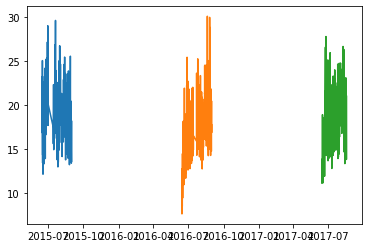

In [89]:
# plot all outdoor temperatures in cleaned dataset
plt.plot(df_2015_X.index, df_2015_X.temp, df_2016_X.index, df_2016_X.temp, df_2017_X.index, df_2017_X.temp) 
plt.show() 

# SELECT FEATURES

In [90]:
# keep indoor air temp and relative humidity
df_2015_X = df_2015_X[['temp','last_temp_2','last_temp_4','last_temp_8','last_temp_24','hum_ratio']]
df_2016_X = df_2016_X[['temp','last_temp_2','last_temp_4','last_temp_8','last_temp_24','hum_ratio']]
df_2017_X = df_2017_X[['temp','last_temp_2','last_temp_4','last_temp_8','last_temp_24','hum_ratio']]

## Add feature for previous temperatures

In [91]:
ls_X = [df_2015_X, df_2016_X, df_2017_X] 


# Add rolling average air temp of the last 48 hours

def addAverage(df):
    df['temp_ave_48hr'] = df['temp'].rolling(48).mean()
    return df 
ls_X2  = [addAverage(df) for df in ls_X]
 
 

# Add the rolling max air temp of the last 24 hours

def addMax(df):
    df['temp_max_24hr'] = df['temp'].rolling(24).max()
    return df 
ls_X3  = [addMax(df) for df in ls_X2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


## Concatenate years into one dataframe

In [92]:
# save a single dataset with all years
df_all_X = pd.concat(ls_X)

## Add feature for time of day 

This step adds a variable to help the model understand the cyclicity of the 24 hours cycle
It borrows from the tutorial provided here: https://towardsdatascience.com/single-and-multi-step-temperature-time-series-forecasting-for-vilnius-using-lstm-deep-learning-b9719a0009de

We want the machine to know that hours 23 and 0 are closer to each other than hours 0 and 4. We know that the period of the cycle is 24 hours. We can use the cos(x) and sin(x) functions. The x in the functions is the hour of the day.

In [93]:
# Extract the hour of day
df_all_X["hour"] = df_all_X.index.hour

# Transform to the cyclical daily feature 
df_all_X["day_cos"] = [np.cos(x * (2 * np.pi / 24)) for x in df_all_X["hour"]]
df_all_X["day_sin"] = [np.sin(x * (2 * np.pi / 24)) for x in df_all_X["hour"]]

# Drop hour of the day as it's own feature
df_all_X.drop('hour', axis=1, inplace=True)

# GET INDOOR AIR TEMPERATURES FOR SAME TIME SPANS

In [98]:
#Get raw data of indoor air temps (what we want to predict) 

df1 = pickle.load(open(DATA_PATH +'/trainY_2015.pkl','rb'))
df2 = pickle.load(open(DATA_PATH +'/trainY_2016.pkl','rb'))
df3 = pickle.load(open(DATA_PATH +'/trainY_2017.pkl','rb'))


# Put in all in one place 
ls_Y = [df1, df2, df3]  
df_Y = pd.concat(ls_Y)

# Drop duplicated date-times

df_Y = df_Y[~df_Y.index.duplicated(keep='first')]

# Drop date-times not in X set

df_all_Y = df_Y[df_Y.index.isin(df_all_X.index)]

In [101]:
df_all_X.columns

Index(['temp', 'last_temp_2', 'last_temp_4', 'last_temp_8', 'last_temp_24',
       'hum_ratio', 'temp_ave_48hr', 'temp_max_24hr', 'day_cos', 'day_sin'],
      dtype='object')

## Plot X feature versus and Y variables

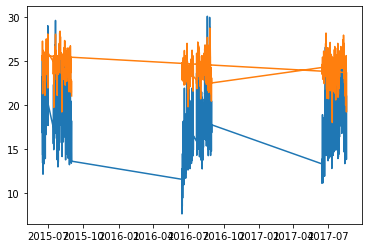

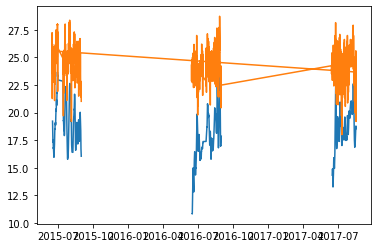

In [102]:
# plot Outdoor (X values) and Indoor (to be predicted)
plt.plot(df_all_X.index, df_all_X.temp, df_all_Y.index, df_all_Y) 
plt.show()

plt.plot(df_all_X.index, df_all_X.temp_ave_48hr, df_all_Y.index, df_all_Y) 
plt.show()

## Count features, label Xs and Ys

In [103]:
features = []

dataset = df_all_X
dataset['indoor_temp']= df_all_Y

num_of_rows = dataset.shape[0]
num_of_columns = dataset.shape[1]
num_of_classes = 1 #default value is 1 for regression. 

for i in range(0, num_of_columns):
      column_name = dataset.columns[i]
      column_type = dataset[column_name].dtypes
      
      if i != num_of_columns - 1: #skip target
          features.append(column_name)
          
target_name = dataset.columns[num_of_columns - 1] 

y_all = dataset[target_name]
x_all = dataset.drop(columns=[target_name])

print("num_of_features: ", len(features))
print("features: ",features)
print("predicting: ",target_name)
print("n :", len(x_all))

num_of_features:  10
features:  ['temp', 'last_temp_2', 'last_temp_4', 'last_temp_8', 'last_temp_24', 'hum_ratio', 'temp_ave_48hr', 'temp_max_24hr', 'day_cos', 'day_sin']
predicting:  indoor_temp
n : 4632


# DEFINE XGBoost MODEL

## Split training and test sets

In [104]:
x = x_all.copy().to_numpy()
# need to reshape Y which contains 1 features (currently it's 0) 
y = y_all.copy().to_numpy().reshape(-1,1)

# NB split should not be an unordered... (shuffle=False)
x_train, testX, y_train, testY = train_test_split(x, y, shuffle = False, test_size= 0.15)
 
train_dim = (x_train.shape, y_train.shape)
test_dim = (testX.shape, testY.shape)

# check
print("train_dim Xs and Y:", train_dim)
print("test_dim Xs and Y", test_dim)

train_dim Xs and Y: ((3937, 10), (3937, 1))
test_dim Xs and Y ((695, 10), (695, 1))


# Sum number of hours that exceed comfort threshold  

Calculate a new 'outcome' for whether the current hour is 'comfortable', based on the temp and humidity (whether in the training or test or predicted sets)